#Preliminary operations

##Import libraries

In [1]:
# import main libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# stats
from scipy import stats
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
# evaluation
from sklearn.metrics import silhouette_score
# distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram
# Principal Component Analysis
from sklearn.decomposition import PCA
from sklearn.metrics.cluster import rand_score
from sklearn.metrics.cluster import adjusted_rand_score

##Mount Google Drive

In [3]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Import datasets

In [4]:
# import dataframe (without outliers)
df = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_opt.xlsx", index_col="Unnamed: 0")
df_emph_high = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_opt_emph_high.xlsx", index_col="Unnamed: 0")
df_emph_low = pd.read_excel("drive/MyDrive/Progetto Data Mining 1/Data Understanding & Preparation/Data prepared final/df_opt_emph_low.xlsx", index_col="Unnamed: 0")

In [5]:
# get data columns
df_data = df[["stft_mean", "mfcc_mean", "skew"]]
df_data_emph_high = df_emph_high[["stft_mean", "mfcc_mean", "skew"]]
df_data_emph_low = df_emph_low[["stft_mean", "mfcc_mean", "skew"]]

# get values from data columns
X = df_data.values
X_emph_high = df_data_emph_high.values
X_emph_low = df_data_emph_low.values

# get emotion lables from each emphasis group
y_emotion = df["emotion"]
y_emotion_emph_high = df_emph_high["emotion"]
y_emotion_emph_low = df_emph_low["emotion"]

# get emotion type from each emphasis group
y_emtype = df["emotion_type"]
y_emtype_emph_high = df_emph_high["emotion_type"]
y_emtype_emph_low = df_emph_low["emotion_type"]

##Normalization

In [6]:
# get StandardScaler
std_scaler = StandardScaler()

# normalise each emphasis group with StandardScaler
X_std = std_scaler.fit_transform(X)
X_std_emph_high = std_scaler.fit_transform(X_emph_high)
X_std_emph_low = std_scaler.fit_transform(X_emph_low)

# get MinMaxScaler
mima_scaler = MinMaxScaler()

# normalise each emphasis group with MinMaxScaler
X_mima = mima_scaler.fit_transform(X)
X_mima_emph_high = mima_scaler.fit_transform(X_emph_high)
X_mima_emph_low = mima_scaler.fit_transform(X_emph_low)

#PCA

In [ ]:
# get PCA
pca = PCA(n_components=3)
model = pca.fit(X_std)
# run PCA
X_pc = model.transform(X_std)

# get the number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = df_data.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca = pd.DataFrame(dic.items())
print(df_pca)

     0          1
0  PC0  stft_mean
1  PC1  mfcc_mean
2  PC2       skew


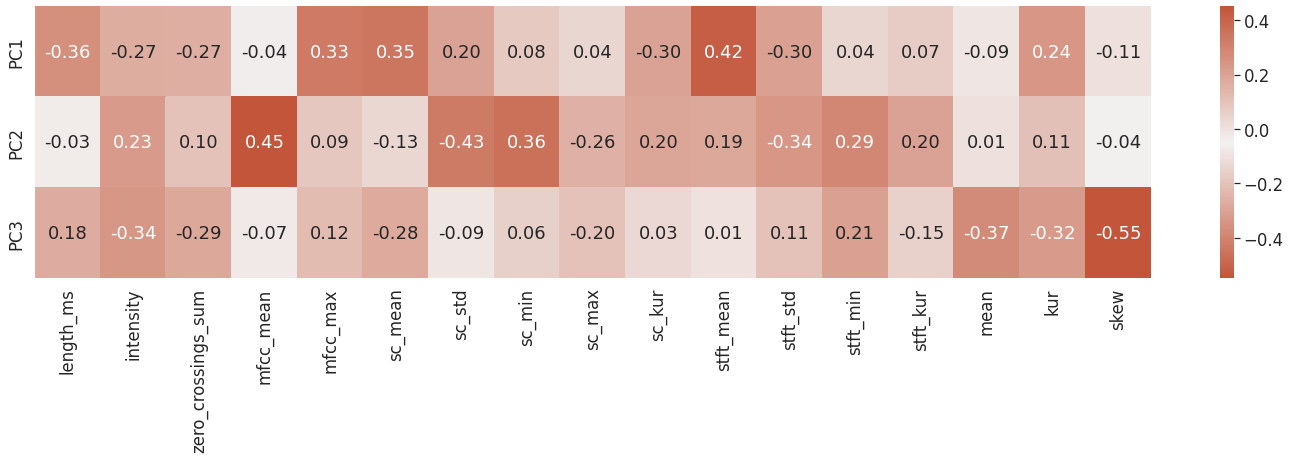

In [ ]:
plt.figure(figsize=(25,5))
sns.set_theme(font_scale=1.5)
cmap = sns.diverging_palette(20, 20, as_cmap=True)
sns.heatmap(model.components_, annot=True, xticklabels=df_data.columns, yticklabels=["PC1", "PC2", "PC3"], fmt=".2f", cmap=cmap)
plt.savefig("PCA.svg", format="svg")

#KMeans

##Choose number of clusters

###Silhouette

In [7]:
sil_list = []

# iterate number of centroids
for k in range(2, 17):
  # get KMeans
  kmeans = KMeans(n_clusters=k, n_init=100, max_iter=3000, random_state=1)
  # fit KMeans
  kmeans.fit(X_std)
  # get silhouette score
  sil_score = silhouette_score(X_std, kmeans.labels_)
  print(str(k) + " " + str(sil_score))

  sil_list.append(sil_score)

2 0.27937280272914317
3 0.29865818977073477
4 0.28574391269046573
5 0.2590116010138972
6 0.25332286611552435
7 0.25266090571397787
8 0.2602040848876295
9 0.2635682195759275
10 0.2606745966457485
11 0.25542735154736335
12 0.25629266766512426
13 0.24992749709137127
14 0.2469614233969697
15 0.24431965967956704
16 0.24902766818788225


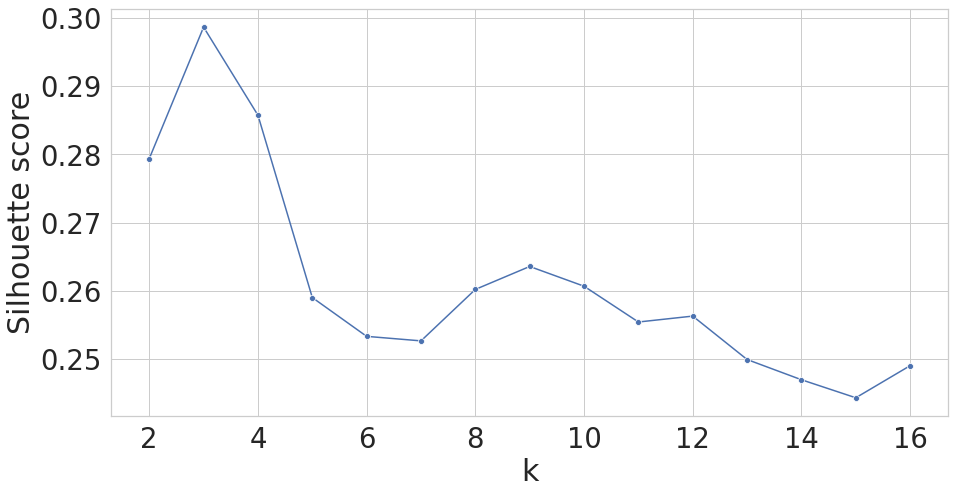

In [8]:
# get silhouette score scatterplot
plt.figure(figsize=(15,7.5))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
sns.lineplot(x=range(2, 17, 1), y=sil_list, marker='o')
plt.ylabel('Silhouette score')
plt.xlabel('k')
plt.savefig("silhouette_kmeans.svg", format="svg")
plt.show()

###SSE

In [9]:
sse_list = []

# iterate number of centroids
for k in range(2, 17):
    # get KMeans
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    # fit KMeans
    kmeans.fit(X_std)
    # get SSE score
    sse_score = kmeans.inertia_
    print(str(k) + " " + str(sse_score))
    
    sse_list.append(kmeans.inertia_)

2 5132.3754786012
3 3672.5702300697767
4 3122.194287660206
5 2750.590402391833
6 2448.5173531839
7 2202.2676221203656
8 1999.6568336238552
9 1845.4391735853596
10 1714.893536184754
11 1610.784245984419
12 1530.71764430437
13 1452.7497748615351
14 1393.4466436029666
15 1339.3058763158847
16 1282.7274578890815


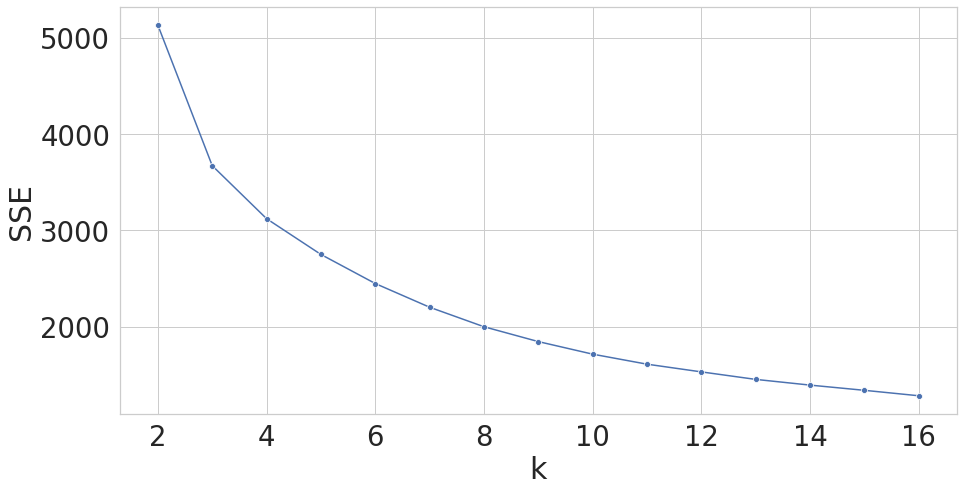

In [10]:
# get SSE curve scatterplot
plt.figure(figsize=(15,7.5))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
sns.lineplot(x=range(2, 17, 1), y=sse_list, marker='o')
plt.ylabel('SSE')
plt.xlabel('k')
plt.savefig("SSE_kmeans.svg", format="svg")
plt.show()

## All emphasis

In [11]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

Text(0.5, 1.0, 'Silhouette = 0.29 / SSE = 3109.66')

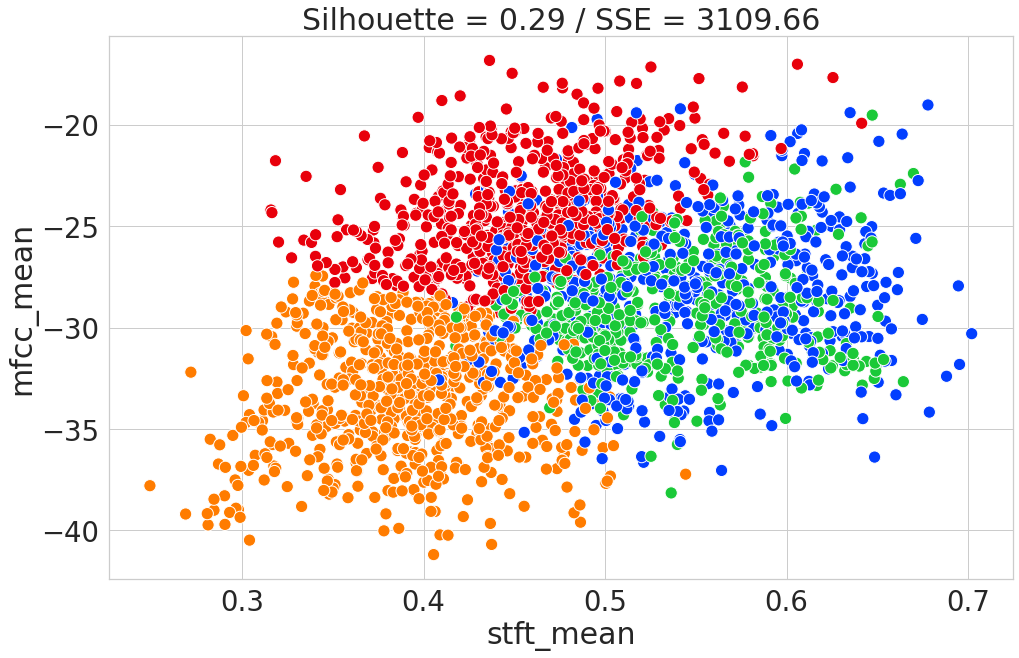

In [12]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('Silhouette = 0.29 / SSE = 3109.66')

In [13]:
centers = kmeans.cluster_centers_
std_scaler.fit(X)
centers = std_scaler.inverse_transform(centers)

In [14]:
df_data['kmeans_labels'] = kmeans.labels_
df_data.groupby("kmeans_labels").count()

<ipython-input-14-8f0a52bd5c3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data['kmeans_labels'] = kmeans.labels_


,stft_mean,mfcc_mean,skew
kmeans_labels,,,
0,607,607,607
1,693,693,693
2,480,480,480
3,672,672,672


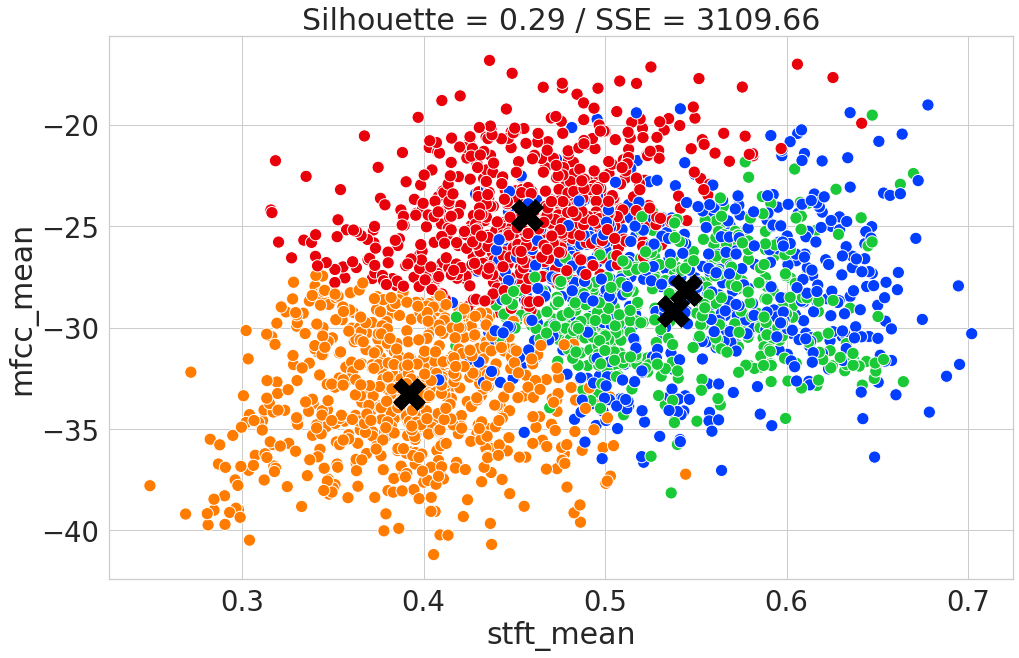

In [15]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('Silhouette = 0.29 / SSE = 3109.66')
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=1000)
plt.savefig("kmeans_all.svg", format="svg")
plt.show()

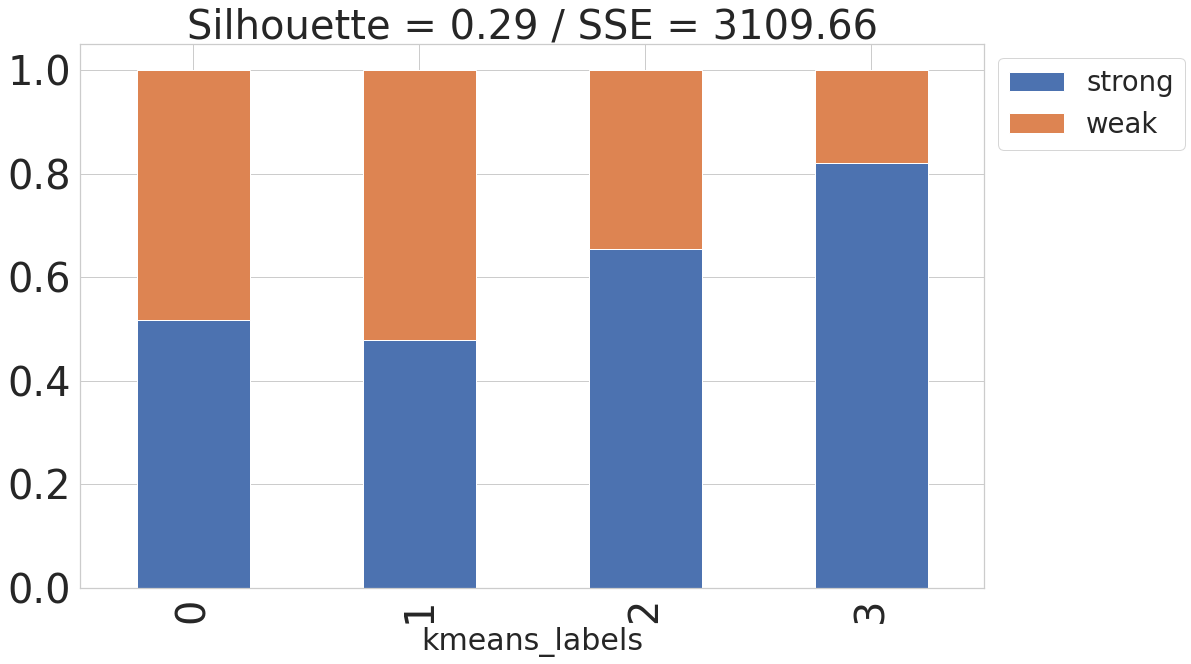

In [16]:
bar_pl = y_emtype.groupby(df_data['kmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=40, figsize=(16.2,10))
plt.title("Silhouette = 0.29 / SSE = 3109.66", fontsize=40)
plt.legend(bbox_to_anchor=(1,1))

plt.savefig("emtype_kmeans_all.svg", format="svg")

plt.show()

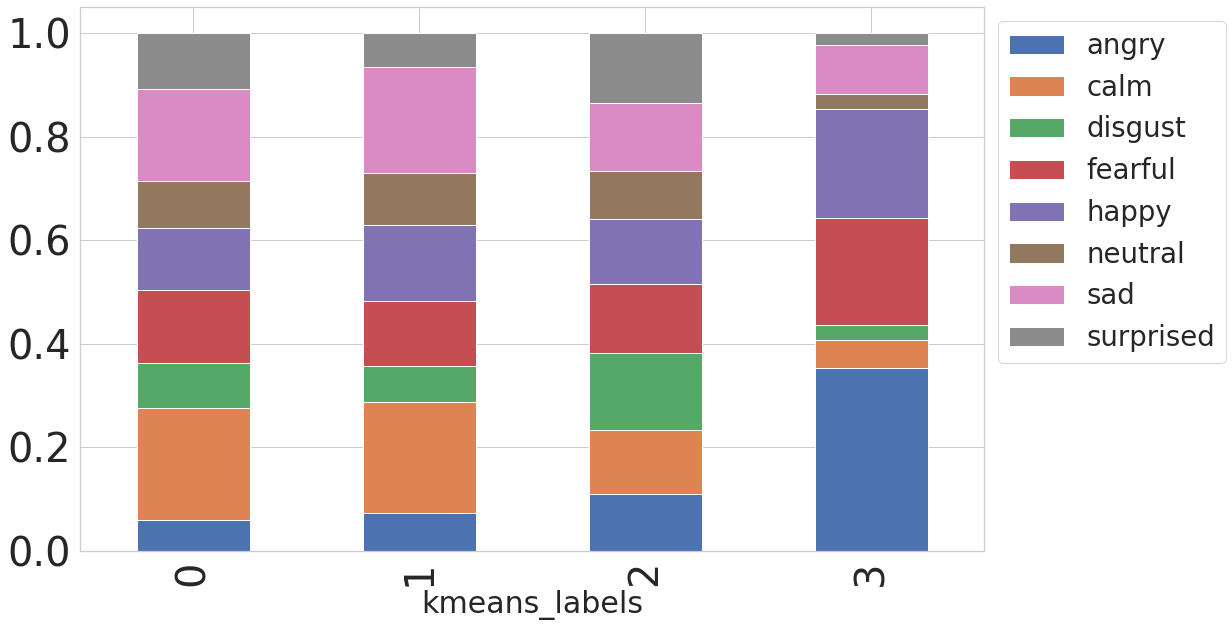

In [17]:
bar_pl = y_emotion.groupby(df_data['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=40, figsize=(16.2,10))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emotions_kmeans_all.svg", format="svg")
plt.show()

## High emphasis

In [18]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std_emph_high)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

Text(0.5, 1.0, 'KMeans clustering')

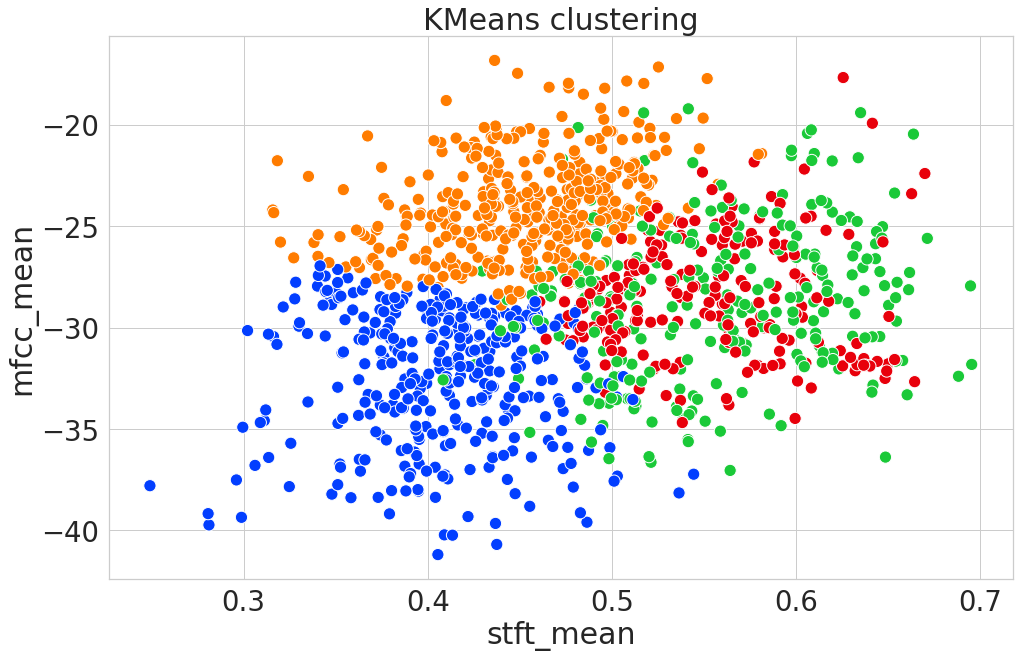

In [19]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('KMeans clustering')

In [20]:
centers = kmeans.cluster_centers_
std_scaler.fit(X_emph_high)
centers = std_scaler.inverse_transform(centers)

In [21]:
df_data_emph_high['kmeans_labels'] = kmeans.labels_
df_data_emph_high.groupby("kmeans_labels").count()

<ipython-input-21-9330cc2a5e4f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_emph_high['kmeans_labels'] = kmeans.labels_


,stft_mean,mfcc_mean,skew
kmeans_labels,,,
0,351,351,351
1,384,384,384
2,270,270,270
3,216,216,216


In [22]:
print(silhouette_score(X_std_emph_high, kmeans.labels_))
print(kmeans.inertia_)

0.2819067370511012
1586.2966626508035


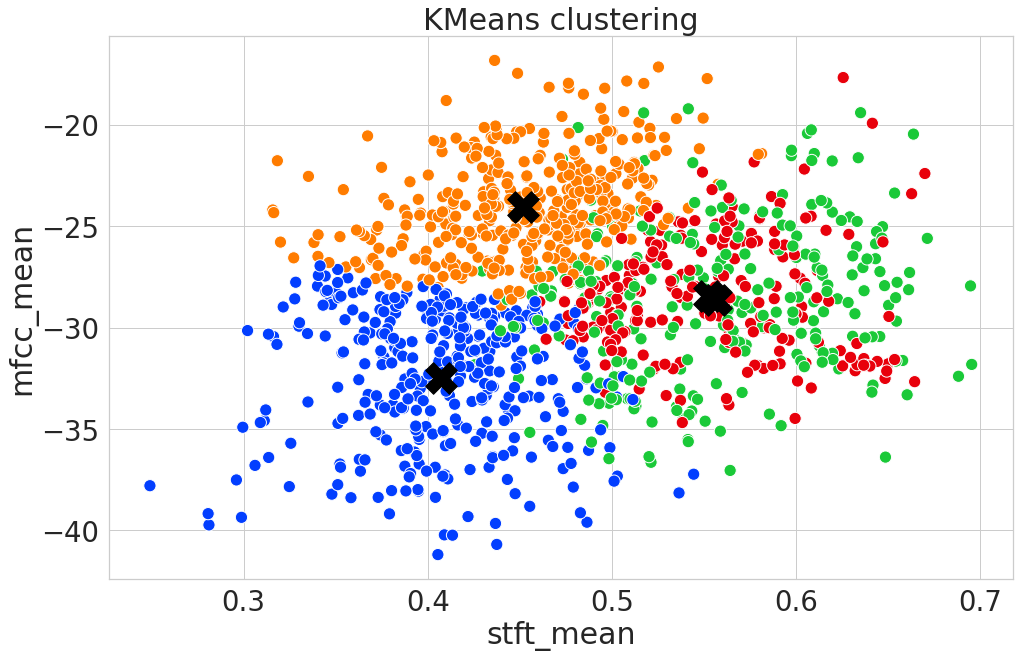

In [23]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_high, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=1000)
plt.savefig("kmeans_emph_high.svg", format="svg")
plt.show()

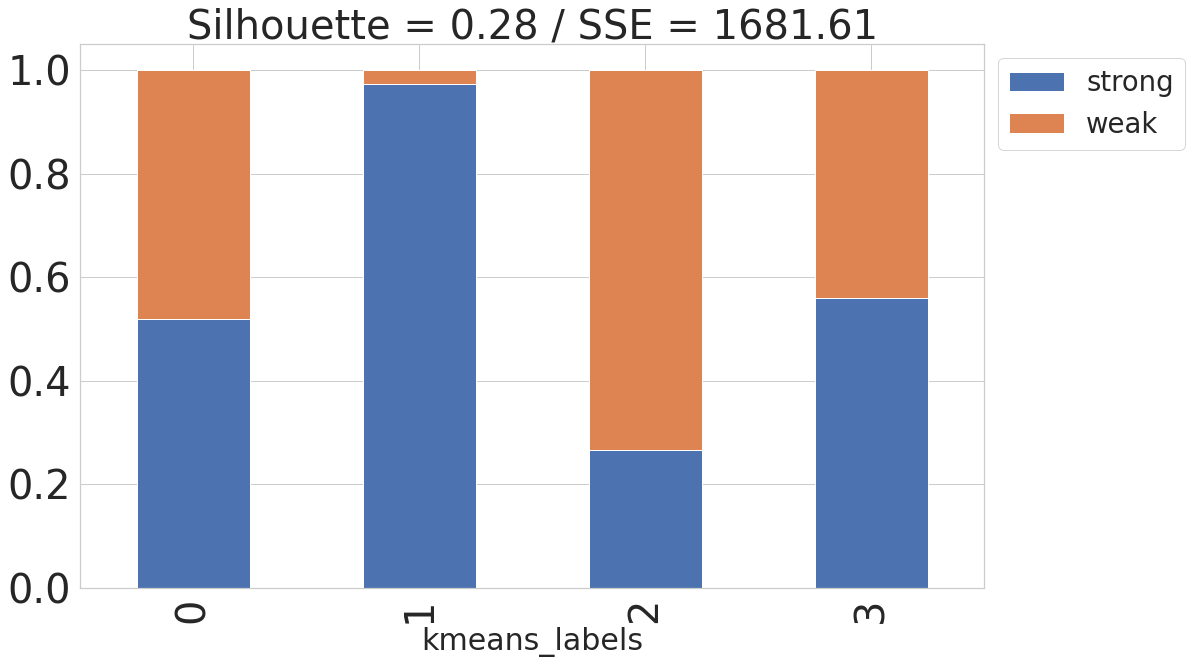

In [24]:
bar_pl = y_emtype_emph_high.groupby(df_data_emph_high['kmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=40, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.title("Silhouette = 0.28 / SSE = 1681.61", fontsize=40)
plt.savefig("emtype_kmeans_emph_high.svg", format="svg")
plt.show()

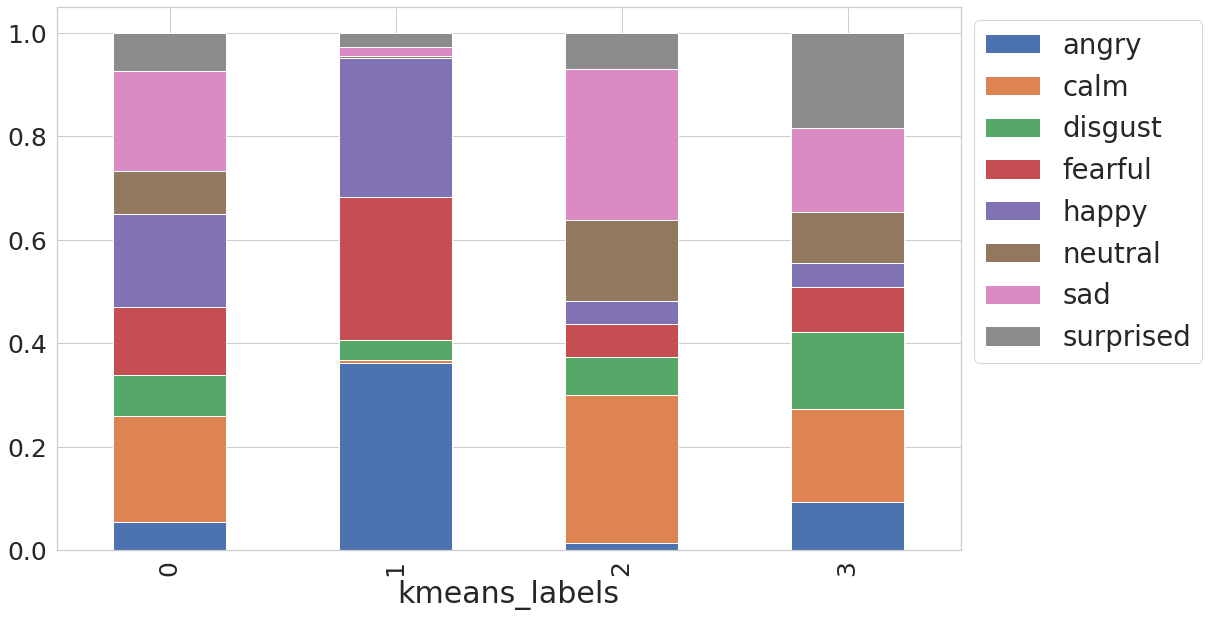

In [25]:
bar_pl = y_emotion_emph_high.groupby(df_data_emph_high['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emtoions_kmeans_emph_high.svg", format="svg")
plt.show()

## Low emphasis

In [26]:
# get KMeans
kmeans = KMeans(n_clusters=4, n_init=100, max_iter=3000, random_state=1)
# fit KMeans
kmeans.fit(X_std_emph_low)

KMeans(max_iter=3000, n_clusters=4, n_init=100, random_state=1)

Text(0.5, 1.0, 'KMeans clustering')

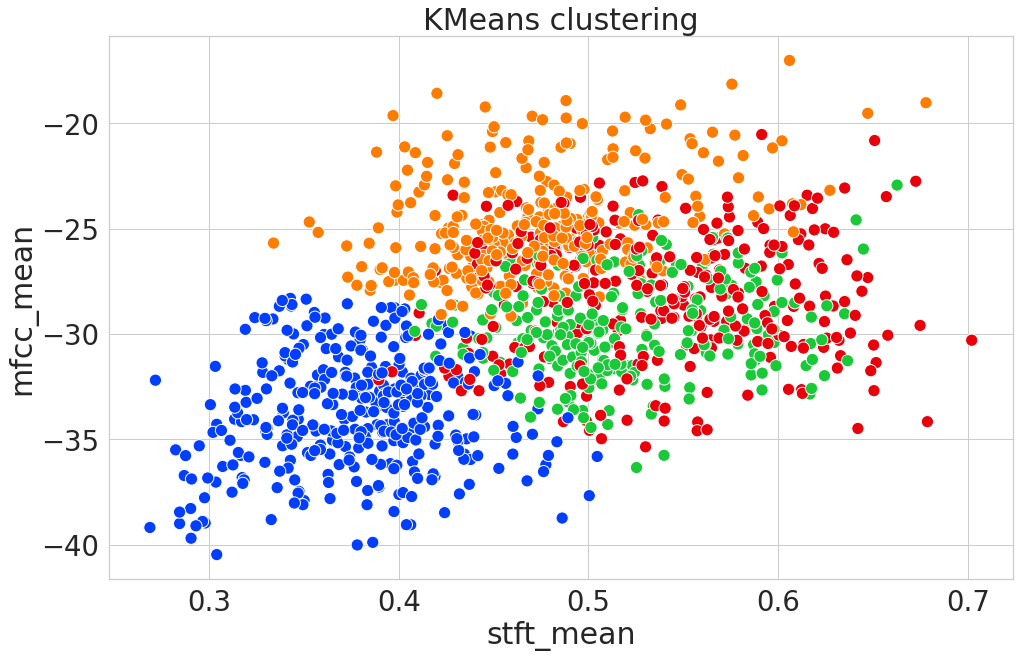

In [27]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_low, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
# Set title with matplotlib
plt.title('KMeans clustering')

In [28]:
centers = kmeans.cluster_centers_
std_scaler.fit(X_emph_low)
centers = std_scaler.inverse_transform(centers)

In [29]:
df_data_emph_low['kmeans_labels'] = kmeans.labels_
df_data_emph_low.groupby("kmeans_labels").count()

<ipython-input-29-70ab7bbab755>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_emph_low['kmeans_labels'] = kmeans.labels_


,stft_mean,mfcc_mean,skew
kmeans_labels,,,
0,359,359,359
1,304,304,304
2,256,256,256
3,312,312,312


In [30]:
print(silhouette_score(X_std_emph_low, kmeans.labels_))
print(kmeans.inertia_)

0.2947340475912605
1488.4739101389634


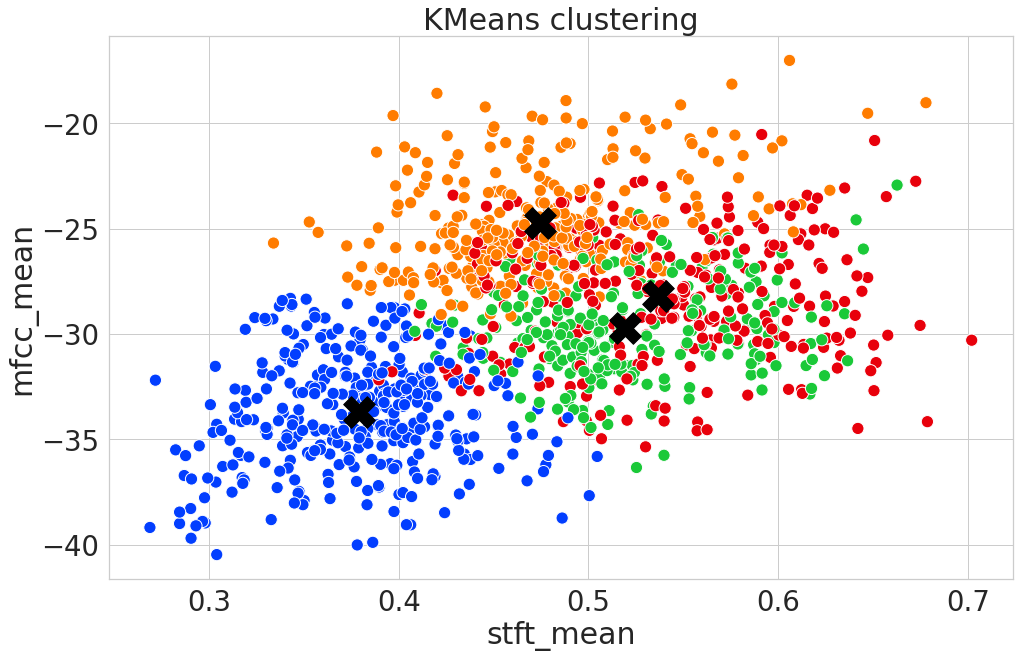

In [31]:
# Set figure size with matplotlib
plt.figure(figsize=(16.2,10))
sns.set_theme(font_scale=2.5)
sns.set_style("whitegrid")
# Create plot
sns.scatterplot(
    data=df_emph_low, 
    x="stft_mean", 
    y="mfcc_mean", 
    hue=kmeans.labels_,
    palette="bright",
    marker="o",
    s=150,
    legend=False
)
 
# Set title with matplotlib
plt.title('KMeans clustering')
plt.scatter(centers[:,0], centers[:,1], c='black', marker='X', s=1000)
plt.savefig("kmeans_emph_low.svg", format="svg")
plt.show()

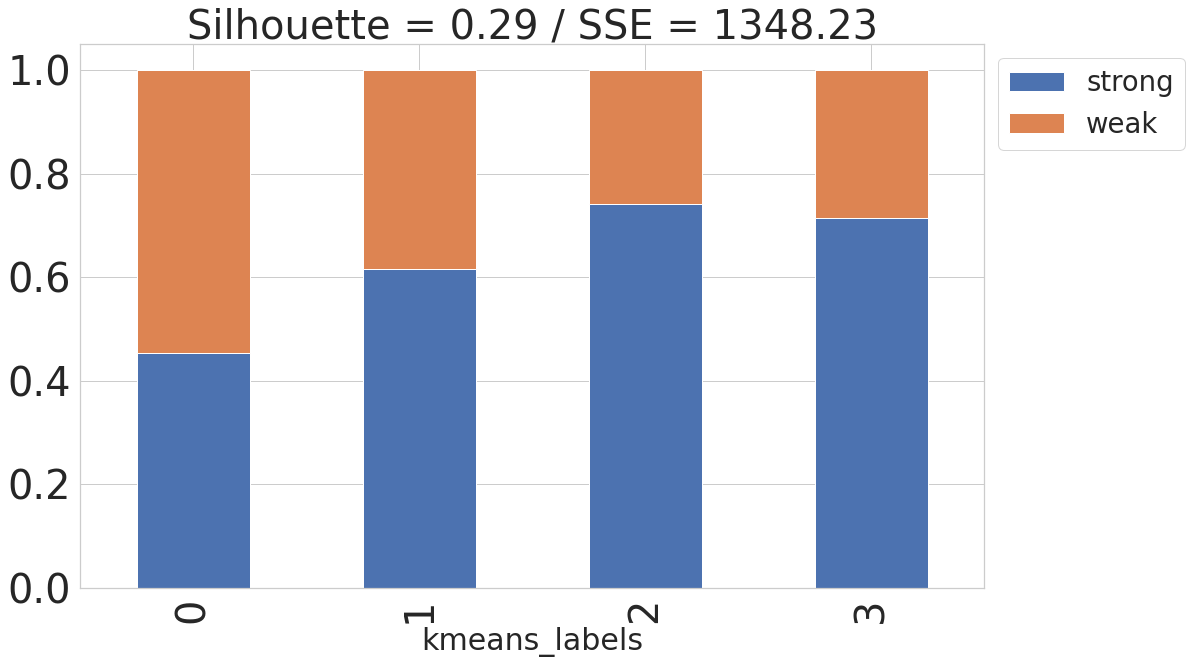

In [32]:
bar_pl = y_emtype_emph_low.groupby(df_data_emph_low['kmeans_labels']).value_counts(normalize=True).unstack(1)

bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=40, figsize=(16.2,10))
plt.legend(bbox_to_anchor=(1,1))
plt.title("Silhouette = 0.29 / SSE = 1348.23", fontsize=40)
plt.savefig("emtype_kmeans_emph_low.svg", format="svg")
plt.show()

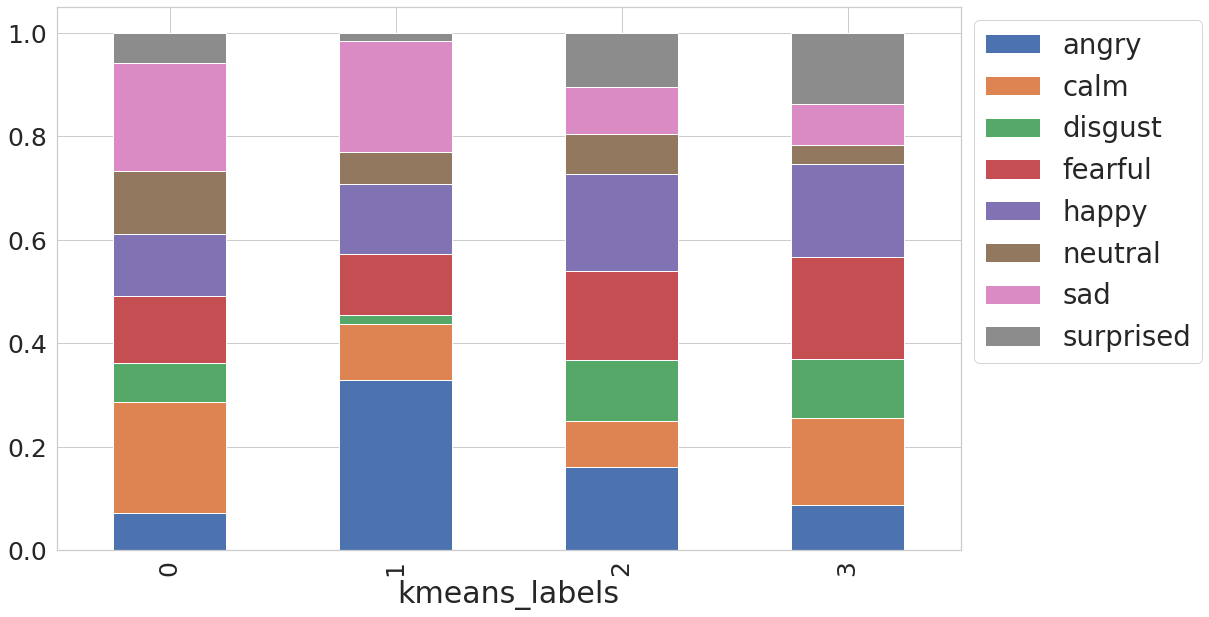

In [33]:
bar_pl = y_emotion_emph_low.groupby(df_data_emph_low['kmeans_labels']).value_counts(normalize=True).unstack(1)
bar_pl.plot(kind='bar', stacked=True, edgecolor='white', fontsize=25, figsize=(16.2,10))

plt.legend(bbox_to_anchor=(1,1))
plt.savefig("emotions_kmeans_emph_low.svg", format="svg")
plt.show()